In [ ]:
import pip

try :
    import torch
    from torchvision import datasets
    from sklearn import preprocessing,ensemble,linear_model
except ImportError:
    pip.main(['Install','torch'])
    pip.main(['Install','torchvision'])
    pip.main(['Install','sklearn'])
    import torch
    from torchvision import datasets
    from sklearn import preprocessing,ensemble,linear_model

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
trainbase=datasets.MNIST(root='./data',download=True,train=True)
testbase=datasets.MNIST(root='./data',download=True,train=False)

X_train=trainbase.data
y_train=trainbase.targets

X_test=testbase.data
y_test=testbase.targets

In [ ]:
def plot_images(X,y):
    for i in range(0,25,5):
        fig=plt.figure(figsize=(12,5))
        ax1=fig.add_subplot(151)
        ax2=fig.add_subplot(152)
        ax3=fig.add_subplot(153)
        ax4=fig.add_subplot(154)
        ax5=fig.add_subplot(155)

        ax1.imshow(X[i+0],cmap='grey')
        ax1.set_title(label=f"digit:{y[i+0].item()}")
        ax2.imshow(X[i+1],cmap='grey')
        ax2.set_title(label=f"digit:{y[i+1].item()}")
        ax3.imshow(X[i+2],cmap='grey')
        ax3.set_title(label=f"digit:{y[i+2].item()}")
        ax4.imshow(X[i+3],cmap='grey')
        ax4.set_title(label=f"digit:{y[i+3].item()}")
        ax5.imshow(X[i+4],cmap='grey')
        ax5.set_title(label=f"digit:{y[i+4].item()}")


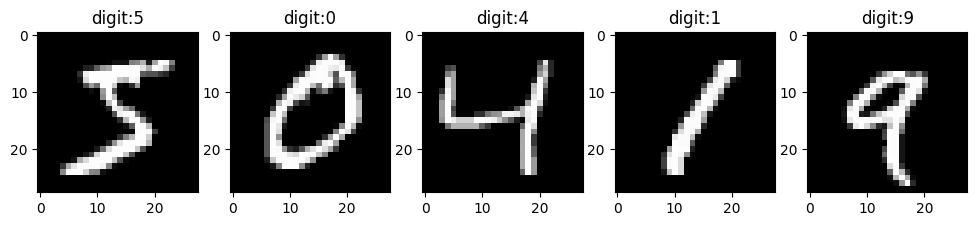

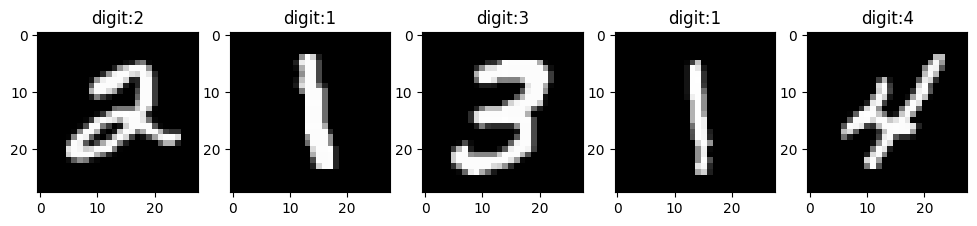

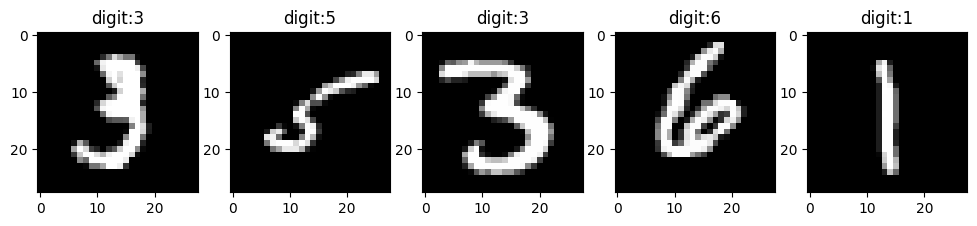

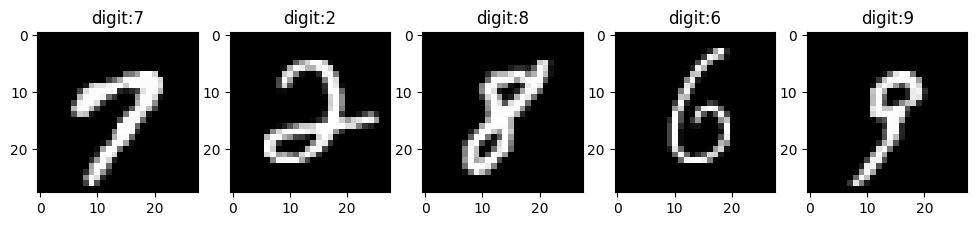

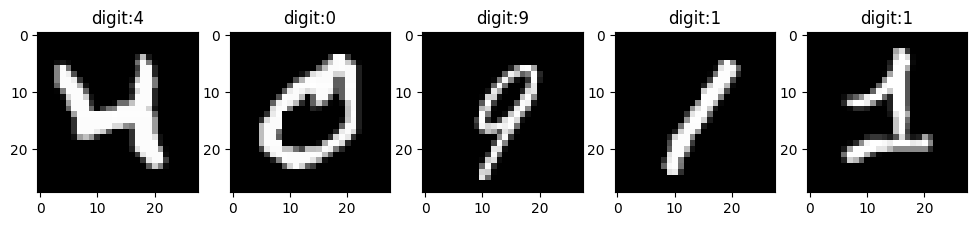

In [ ]:
plot_images(X_train,y_train)

In [ ]:
def create_stratified_subset(X,y,l,batchsize):
    dicimages={i:[] for i in range(l)}

    for img, label in zip(X,y):
        dicimages[label.item()].append(img)

    X_new=[]
    y_new=[]

    for i in range(l):
        indices=torch.randperm(len(dicimages[i]))[:batchsize]
        sampled_images=[dicimages[i][j] for j in indices.numpy()]
        X_new.extend(sampled_images)
        y_new.extend([i]*batchsize)

    X_new=torch.stack(X_new)
    y_new=torch.tensor(y_new)

    for i in range(100):
        per= torch.randperm(len(X_new))
        X_new=X_new[per]
        y_new=y_new[per]
    return X_new,y_new

In [ ]:
X_train,y_train=create_stratified_subset(X_train,y_train,len(trainbase.classes),1000)

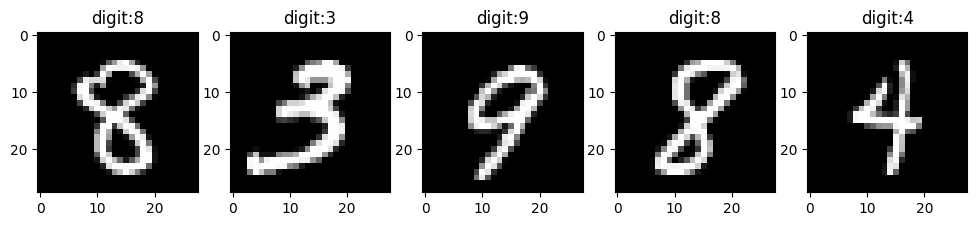

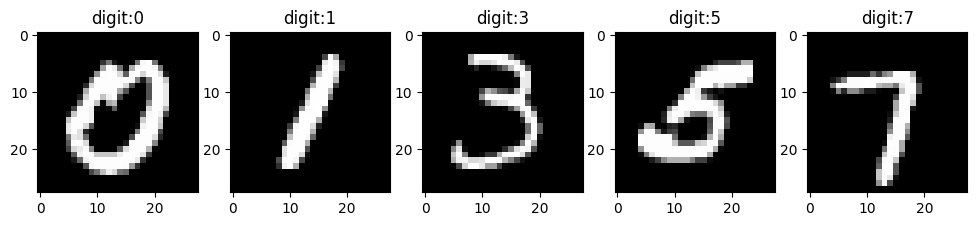

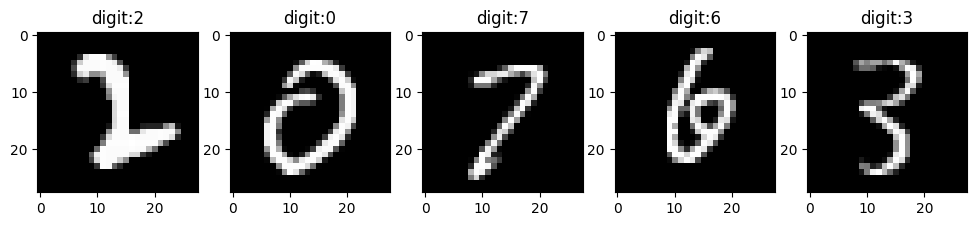

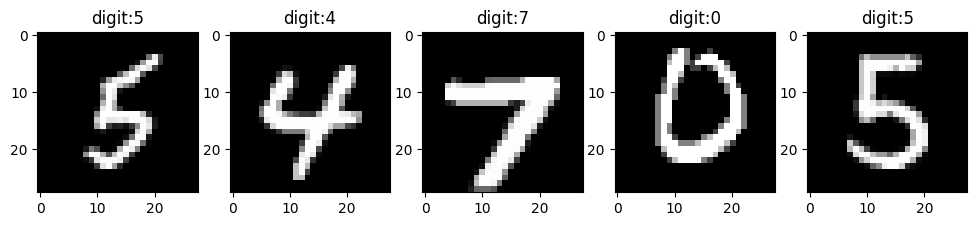

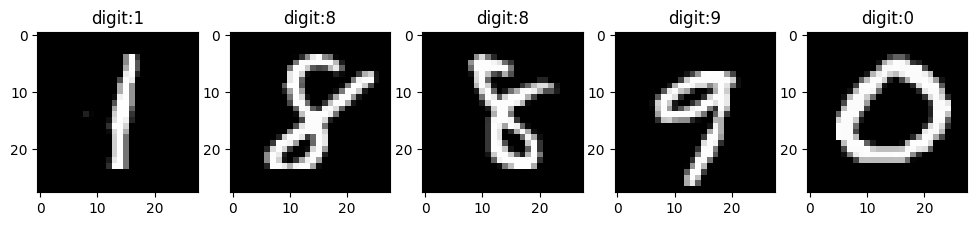

In [ ]:
plot_images(X_train,y_train)

Train on MNIST dataset using an MLP. The original training dataset contains 60,000 images and test contains 10,000 images. If you are short on compute, use a stratified subset of a smaller number of images. But, the test set remains the same 10,000 images. Compare against RF and Logistic Regression models.  The metrics can be: F1-score, confusion matrix. What do you observe? What all digits are commonly confused?

Let us assume your MLP has 30 neurons in first layer, 20 in second layer and then 10 finally for the output layer (corresponding to 10 classes)


In [ ]:
scaler_model=preprocessing.StandardScaler()
X_train_scaled=torch.tensor(scaler_model.fit_transform(X_train.reshape(-1,28*28)).reshape(X_train.shape)).float()
X_test_scaled=torch.tensor(scaler_model.fit_transform(X_test.reshape(-1,28*28)).reshape(X_test.shape)).float()

In [ ]:
X_train_scaled.shape,X_test_scaled.shape

(torch.Size([10000, 28, 28]), torch.Size([10000, 28, 28]))

In [ ]:
from torch import nn

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.hl1=nn.Linear(28*28,30)
        self.hl2=nn.Linear(30,20)
        self.hl3=nn.Linear(20,10)

    def forward(self,x):
        x=x.flatten()
        x=torch.relu(self.hl1(x))
        x=torch.relu(self.hl2(x))
        x=self.hl3(x)
        return x

net_mlp=MLP()

In [ ]:
def output_layer(net,X):
    outputs=[]
    with torch.no_grad():
        for i in range(len(X)):
            layer1=torch.relu(net.hl1(X[i].flatten()))
            layer2=torch.relu(net.hl2(layer1))
            outputs.append(layer2.numpy())
    return np.array(outputs)

In [ ]:
untrained_output=output_layer(net_mlp.eval(),X_train_scaled)

In [ ]:
def train_model(net,X,y,lr,epochs):
    criterion=nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(net_mlp.parameters(),lr)
    y=y.long()
    for epoch in range(epochs):
        per=torch.randperm(len(X))
        X=X[per]
        y=y[per]
        for i in range(len(X)):
            optimizer.zero_grad()
            output=net(X[i])
            loss=criterion(output,y[i])
            loss.backward()
            optimizer.step()

train_model(net_mlp,X_train_scaled,y_train,0.001,10)

In [ ]:
net_mlp.eval()

MLP(
  (hl1): Linear(in_features=784, out_features=30, bias=True)
  (hl2): Linear(in_features=30, out_features=20, bias=True)
  (hl3): Linear(in_features=20, out_features=10, bias=True)
)

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

In [ ]:
y_pred=[]

for i in range(len(X_test_scaled)):
    output=net_mlp(X_test_scaled[i])
    _,prediction=torch.max(output.data,0)
    y_pred.append(prediction)

mlp_f1score=f1_score(y_test,y_pred,average='weighted')
mlp_confusionmatrix=confusion_matrix(y_test,y_pred)

In [ ]:
RandomForest_model=ensemble.RandomForestClassifier(n_estimators=50)
RandomForest_model.fit(X_train_scaled.reshape(-1,28*28),y_train)

RandomForestClassifier(n_estimators=50)

In [ ]:
rf_predict=torch.tensor(RandomForest_model.predict(X_test_scaled.reshape(-1,28*28)))
rf_accuarcy=accuracy_score(y_test,rf_predict)
rf_f1score=f1_score(y_test,rf_predict,average='weighted')
rf_confusionmatrix=confusion_matrix(y_test,rf_predict)

In [ ]:
LogesticRegression_model=linear_model.LogisticRegression(max_iter=1000)
LogesticRegression_model.fit(X_train_scaled.reshape(-1,28*28),y_train)

KeyboardInterrupt: 

In [ ]:
lr_predict=torch.tensor(LogesticRegression_model.predict(X_test_scaled.reshape(-1,28*28)))
lr_accuracy=accuracy_score(y_test,lr_predict)
lr_f1score=f1_score(y_test,lr_predict,average='weighted')
lr_confusionmatrix=confusion_matrix(y_test,lr_predict)

In [ ]:
mlp_f1score,rf_f1score,lr_f1score

print(f'f1-score for MLP model:{mlp_f1score}')
print(f'f1-score for Random Forest model:{rf_f1score}')
print(f'f1-score for Logestic Regression model:{lr_f1score}')

f1-score for MLP model:0.8342056091964887
f1-score for Random Forest model:0.9300313219270884
f1-score for Logestic Regression model:0.8910525781305964


The performance comparison indicates that MLP model has better performance then Random Forest Model and Logestic Regression Model in terms of f-1 score.Though the margin between MLP model and Random Forest Model is considerably less ,one reason behind it could be usage of fewer number of nuerons in hidden layers, increasing number of neurons could eventually increases the performance of the MLP model

In [ ]:
import seaborn as sns

In [ ]:
def plot_confusionmatrix(matrix,l):
    fig=plt.figure(figsize=(8,6))
    values=np.arange(10)
    sns.heatmap(matrix,square=True,annot=True,fmt='d',xticklabels=values,yticklabels=values)
    plt.title(label=f"Confusion Matrix For {l}")
    plt.xlabel('Actual Digit')
    plt.ylabel('Predicted Digit')
    plt.show()

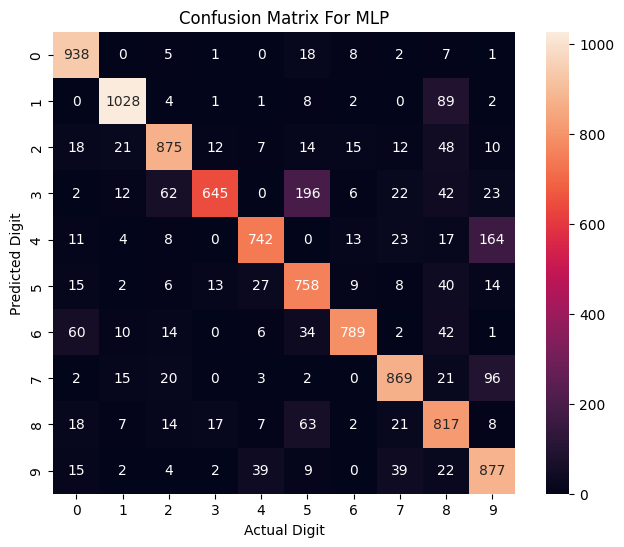

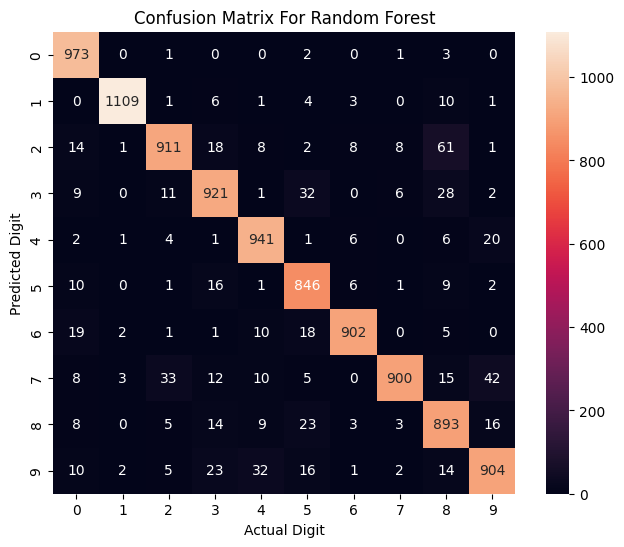

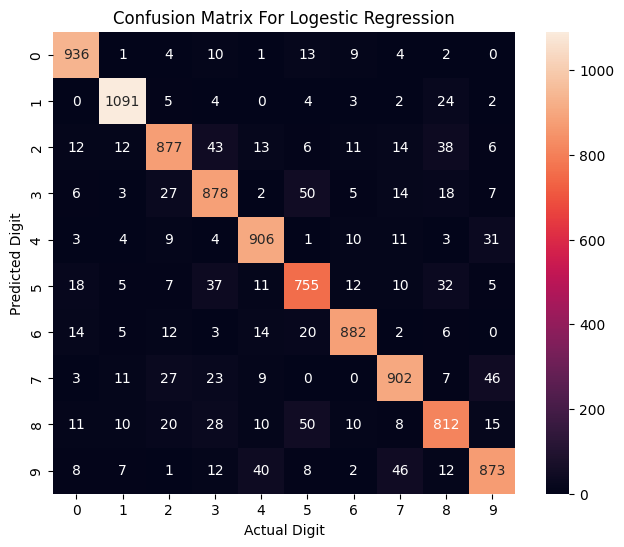

In [ ]:
plot_confusionmatrix(mlp_confusionmatrix,'MLP')
plot_confusionmatrix(rf_confusionmatrix,'Random Forest')
plot_confusionmatrix(lr_confusionmatrix,'Logestic Regression')

Comparing the three confusion matrix the digits (3-5), (4-9) are been common confused

On the trained MLP, plot the t-SNE for the output from the layer containing 20 neurons for the 10 digits. Contrast this with the t-SNE for the same layer but for an untrained model. What do you conclude?

In [ ]:
trained_output=output_layer(net_mlp.eval(),X_train_scaled)

In [ ]:
from sklearn.manifold import TSNE

def apply_tsne(data):
    tsne=TSNE(n_components=2,random_state=42)
    return tsne.fit_transform(data)

trained_tsne=apply_tsne(trained_output)
untrained_tsne=apply_tsne(untrained_output)

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne(ax,tsne_data,digits,title):

    unique_labels=np.unique(digits)
    colors=plt.cm.get_cmap('viridis',len(unique_labels))

    for i, label in enumerate(unique_labels):
        class_mask=(digits==label)
        ax.scatter(tsne_data[class_mask,0],tsne_data[class_mask,1],color=colors(i),alpha=0.4,label=f'Class {label}')

    ax.set_title(title)
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.legend()
    ax.grid(True)

fig=plt.figure(figsize=(12,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
plot_tsne(ax1,trained_tsne, y_train.numpy(),'t-SNE of Trained Model Outputs')
plot_tsne(ax2,untrained_tsne,y_train.numpy(),'t_SNE of Untrained Model Outputs')

The t-SNE plot for trained model consists of well defined clustures for different digits which indicates that the trained model has learned the ability to differentiate between digits. While in t-SNE plot for untrained model showcases a scattered distribution of the classes

Conclusion:The model can not differentiate the digits without training

Now, use the trained MLP to predict on the Fashion-MNIST dataset. What do you observe? How do the embeddings (t-SNE viz for the second layer compare for MNIST and Fashion-MNIST images)

In [ ]:
trainbase_fas=datasets.FashionMNIST(root='./data',download=True,train=True)
testbase_fas=datasets.FashionMNIST(root='./data',download=True,train=False)

X_train_fas=trainbase_fas.data
y_train_fas=trainbase_fas.targets

X_test_fas=testbase_fas.data
y_test_fas=testbase_fas.targets

plot_images(X_train_fas,y_train_fas)

In [ ]:
X_train_fas,y_train_fas=create_stratified_subset(X_train_fas,y_train_fas,len(trainbase_fas.classes),1000)

In [ ]:
scaler_model=preprocessing.StandardScaler()
X_train_scaled_fas=torch.tensor(scaler_model.fit_transform(X_train_fas.reshape(-1,28*28)).reshape(X_train_fas.shape)).float()
X_test_scaled_fas=torch.tensor(scaler_model.fit_transform(X_test_fas.reshape(-1,28*28)).reshape(X_test_fas.shape)).float()

In [ ]:
trained_output_fas=output_layer(net_mlp.eval(),X_train_scaled_fas)
trained_tsne_fas=apply_tsne(trained_output_fas)

In [ ]:
fig=plt.figure(figsize=(12,5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
plot_tsne(ax1,trained_tsne_fas,y_train_fas.numpy(),'t_SNE of Fashion MINST Dataset')
plot_tsne(ax2,trained_tsne, y_train.numpy(),'t-SNE of MINST Dataset')

When t-SNE plot for Fashion MNSIT Dataset is analysed it can be observed some clustures that are less defined, which indicates that Fashion MNSIT dataset consists of complex dataset and requires more complex MLP model for differentiating between the digits